In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [2]:
# Load the saved CNN model
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5") 
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Ensure that the CNN layers are frozen (not trainable)
for layer in cnn_model.layers:
    layer.trainable = False


In [3]:
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
# Image preprocessing for train and test sets
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare the train and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Binary classification (benign vs. malignant)
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Binary classification (benign vs. malignant)
    shuffle=False
)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction function
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Extract features for the train and test datasets
train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

# Print the shape of extracted features
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

54/54 [==============================] - 40s 742ms/step
Train features shape: (6185, 86528)
Test features shape: (1724, 86528)


In [6]:
# Scale the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training features and transform both train and test features
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


In [7]:
# Train the RF classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_scaled, train_labels)

# Print a message confirming the classifier is trained
print("Random Forest model trained using CNN features.")

Random Forest model trained using CNN features.


In [8]:
# Predict using the trained RF model on the test dataset
test_predictions = rf_classifier.predict(test_features_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy without PCA: {accuracy:.4f}")

Test Accuracy without PCA: 0.8689


In [9]:
# Print the classification report
print("Classification Report without PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))


Classification Report without PCA:
              precision    recall  f1-score   support

      BENIGN       0.82      0.74      0.78       542
   MALIGNANT       0.89      0.93      0.91      1182

    accuracy                           0.87      1724
   macro avg       0.86      0.83      0.84      1724
weighted avg       0.87      0.87      0.87      1724



1/1 [==============================] - 0s 112ms/step


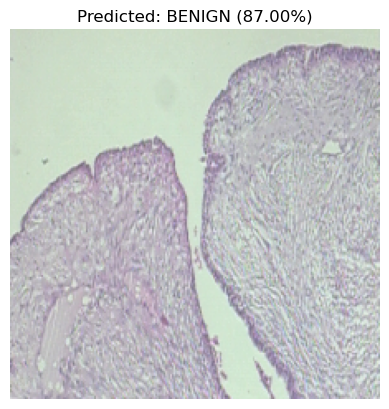

Prediction Probabilities:
BENIGN: 0.87
MALIGNANT: 0.13


In [10]:
# Function to predict a single image
def predict_image(image_path, model, rf_classifier, scaler, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using CNN
    features = model.predict(img_array)

    # Scale the extracted features
    features_scaled = scaler.transform(features)

    # Predict using the trained RF classifier
    prediction = rf_classifier.predict(features_scaled)
    probabilities = rf_classifier.predict_proba(features_scaled)[0]

    # Get the class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\phyllodes_tumor\SOB_B_PT_14-21998AB\40X\SOB_B_PT-14-21998AB-40-007.png"
predict_image(image_path, cnn_model, rf_classifier, scaler, train_generator.class_indices)


1/1 [==============================] - 0s 82ms/step


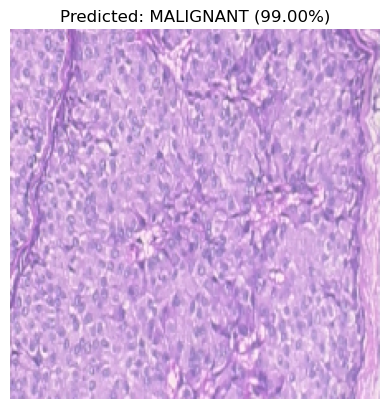

Prediction Probabilities:
BENIGN: 0.01
MALIGNANT: 0.99


In [11]:
# Function to predict a single image
def predict_image(image_path, model, rf_classifier, scaler, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using CNN
    features = model.predict(img_array)

    # Scale the extracted features
    features_scaled = scaler.transform(features)

    # Predict using the trained RF classifier
    prediction = rf_classifier.predict(features_scaled)
    probabilities = rf_classifier.predict_proba(features_scaled)[0]

    # Get the class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-014.png"
predict_image(image_path, cnn_model, rf_classifier, scaler, train_generator.class_indices)


In [12]:
import joblib

# Save the trained RF classifier
rf_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\rf_model_without_pca.pkl'
joblib.dump(rf_classifier, rf_model_path)
print(f"RF model saved at {rf_model_path}")

# Save the StandardScaler
scaler_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_without_pca.pkl'
joblib.dump(scaler, scaler_model_path)
print(f"Scaler saved at {scaler_model_path}")

RF model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\rf_model_without_pca.pkl
Scaler saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_without_pca.pkl
